## PINN for Burger Equation
https://colab.research.google.com/github/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb#scrollTo=1PlqQM9aZEkd

In [1]:
import tensorflow as tf
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = .01/pi

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

### 2. Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)).
Our numerical experiments indicate that this strategy slightly improves the observed convergence rate, but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [2]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

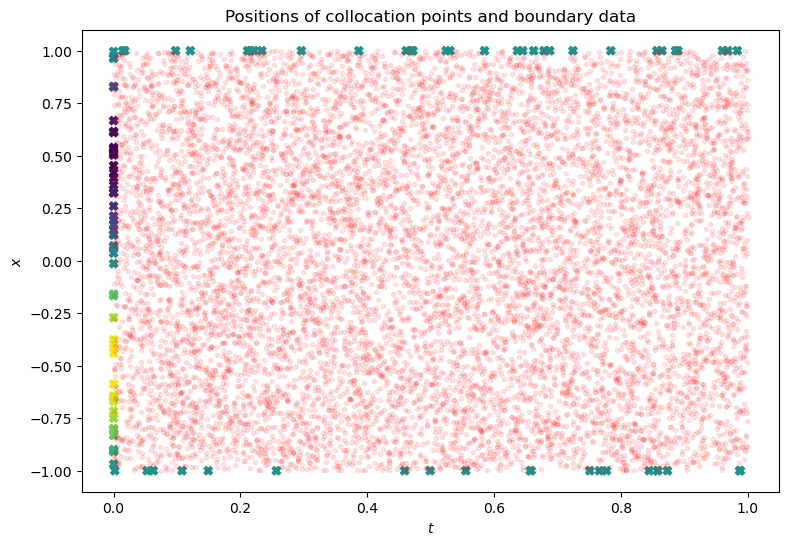

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
plt.scatter(t_0, x_0, c=u_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, x_b, c=u_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, x_r, c='r', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');
#plt.savefig('Xdata_Burgers.pdf', bbox_inches='tight', dpi=300)

In [4]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (t,x) := \partial_t u_\theta (t,x) + \mathcal{N}[u_\theta] (t,x).
\end{align}
$$

of the nonlinear PDE in the points $X_r = \{(t^r_i,x^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Burgers equation, this entails computing $\partial_t u_\theta$, $\partial_x u_\theta$ and $\partial_{xx} u_\theta$.
In TensorFlow, this is done via a `GradientTape`, see also the [documentation](https://www.tensorflow.org/api_docs/python/tf/GradientTape), which keeps track of the `watched` variables, in our case `t` and `x`, in order to compute the derivatives.

In [5]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

The next function computes the loss for our model

$$
\begin{align}
    \phi_\theta(X) := \phi_\theta^r(X^r) + \phi_\theta^0(X^0) + \phi_\theta^b(X^b),
\end{align}
$$

as a function of our the training data.
The collocation points are given by `X_r`, the initial and boundary data is contained in `X_data = [X_0, X_b]` and `u_data = [u_0, u_b]`.

In [6]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [7]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

In [8]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [9]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 5000
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 4.52835858e-01
It 00050: loss = 1.79998100e-01
It 00100: loss = 1.28131628e-01
It 00150: loss = 9.74254459e-02
It 00200: loss = 8.58342648e-02
It 00250: loss = 1.62842110e-01
It 00300: loss = 5.77191189e-02
It 00350: loss = 8.28939453e-02
It 00400: loss = 7.78498799e-02
It 00450: loss = 2.21710578e-01
It 00500: loss = 1.02385327e-01
It 00550: loss = 1.99783161e-01
It 00600: loss = 1.74607217e-01
It 00650: loss = 3.13087553e-02
It 00700: loss = 1.51710108e-01
It 00750: loss = 8.33086297e-02
It 00800: loss = 6.89938292e-02
It 00850: loss = 4.80599254e-02
It 00900: loss = 4.42183539e-02
It 00950: loss = 4.28135172e-02
It 01000: loss = 4.09744829e-02
It 01050: loss = 3.93161178e-02
It 01100: loss = 3.88766043e-02
It 01150: loss = 3.84093709e-02
It 01200: loss = 3.78965139e-02
It 01250: loss = 3.73389460e-02
It 01300: loss = 3.67058888e-02
It 01350: loss = 3.60732675e-02
It 01400: loss = 3.54343727e-02
It 01450: loss = 3.47410217e-02
It 01500: loss = 3.39652412e-02
It 01550

Text(0.5, 0.92, 'Solution of Burgers equation')

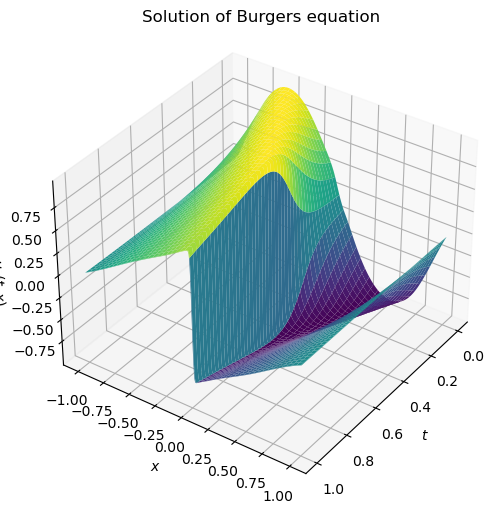

In [10]:
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis')
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation')
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

Text(0, 0.5, '$\\phi_{n_{epoch}}$')

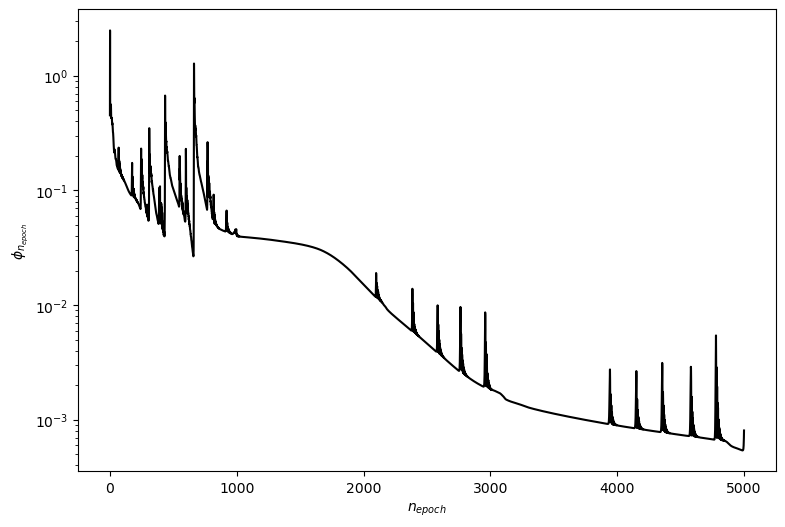

In [11]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('$\\phi_{n_{epoch}}$')